In [1]:
import pulp
import matplotlib.pyplot as plt
import numpy as np

# Piecewise Linear Approximation
(The Convex Combination Method)

It is often tha case that the objective function of a constraint would better be described by a nonlinear function, while LP requires us to formulate everything as linear relationships. If, however, it is the case that this nonlinear relation can be describede as a separable function, we can utilize a technique that is called Piecewise Linear Approximation, which divides the the nonlinear dunction into smaller, linearly approximated segments. Using this technique, it may be possible to generate an integer programming model, or sometimes even a linear programming model

A separable function is a function where all the variabels can be separated from eachother. This means that no variable is interacting nonlinearly with another variable, only itselfs.

An example of a separable function:

$$x_1^2 + \frac{1}{x_2} = f_1(x_1) + f_2(x_2)$$

An example of a non-separable function:

$$x_1 x_2 + \frac{1}{x_1 + x_2} = f_1(x_1, x_2) + f_2(x_1, x_2)$$

## Convex/concave nonlinear functions
If the nonlinear function is convex for a minimization problems (or concav for maximizaztion), only the following constraints are needed. There is not need to explicitly specify that the function needs to be on the line, since the, in this case, minimization will force the value down on the convex line.

$$
\begin{align*}
\sum_i^\Lambda{\lambda_i x_i} &= x & i \in I\\
\sum_i^\Lambda{\lambda_i f(x_i)} &= y & i \in I \\
\sum_i^\Lambda{\lambda_i} &= 1 & i \in I \\
\end{align*}
$$

- $I$ is a set of the same size as the number of samples from the non-linear function
- $(x_i,y_i)$ are constants that are sampled in advance from a nonlinear function
- $\lambda_i$ is a continous variable in the range $[0,1]$ that describes the percentage of which a how much each point $(x_i,y_i)$ are should contribute to the final value of $(x,y)$
- $x$ and $y$ are the varaibles that the optimization problem are using

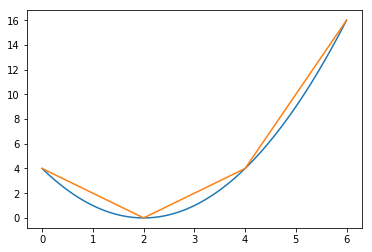

In [2]:
x_min = 0
x_max = 6
x_samples = 4

# Nonlinear function
f = lambda x: (x-2)**2

# Sampling the nonlinear function
xs = np.linspace(x_min,x_max,x_samples)
ys = np.array(f(xs))

x_ls = np.linspace(x_min,x_max,100)
plt.plot(x_ls,f(x_ls))
plt.plot(xs,ys)

In [3]:
x = pulp.LpVariable('x', lowBound=x_min, upBound=x_max)
y = pulp.LpVariable('y')
l = [pulp.LpVariable(f'lambda_{i}', lowBound=0, upBound=1) for i in range(x_samples)]
#w = [pulp.LpVariable(f'w_{i}', cat='Binary') for i in range(x_samples-1)]

In [4]:
m = pulp.LpProblem("Linear Piecewise Approximation", sense=pulp.LpMinimize)

# Minimize
m += y

# Subject to
m += x == np.sum([xs[i] * l[i] for i in range(x_samples)])
m += y == np.sum([ys[i] * l[i] for i in range(x_samples)])
m += np.sum(l) == 1

In [5]:
m

Linear Piecewise Approximation:
MINIMIZE
1*y + 0
SUBJECT TO
_C1: - 2 lambda_1 - 4 lambda_2 - 6 lambda_3 + x = 0

_C2: - 4 lambda_0 - 4 lambda_2 - 16 lambda_3 + y = 0

_C3: lambda_0 + lambda_1 + lambda_2 + lambda_3 = 1

VARIABLES
lambda_0 <= 1 Continuous
lambda_1 <= 1 Continuous
lambda_2 <= 1 Continuous
lambda_3 <= 1 Continuous
x <= 6 Continuous
y free Continuous

In [6]:
status = m.solve()
pulp.LpStatus[status]

'Optimal'

In [7]:
x.value(), y.value()

(2.0, 0.0)

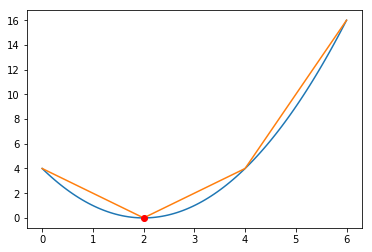

In [8]:
plt.plot(x_ls,f(x_ls))
plt.plot(xs,ys)
plt.plot(x.value(), y.value(), 'ro')

## Non-convex (or -concave), nonlinear functions
If the nonlinear function is non-convex, additional requirements must be added to ensure that at most two adjacent $\lambda$'s are greater than zero. This is done by adding binary variables, which transforms the problem from an LP to a MILP problem.
$$
\begin{align*}
\sum_i^\Lambda{\lambda_i x_i} &= x \\
\sum_i^\Lambda{\lambda_i f(x_i)} &= f(x) \\
\sum_i^\Lambda{\lambda_i} &= 1 \\
\sum_i^{\Lambda-1}{w_i} &= 1 \\
w_i &\leq \lambda_i + \lambda_{i+1} & i \in [0,1,\ldots,I-1]
\end{align*}
$$

- $I$ is a set of the same size as the number of samples from the non-linear function
- $(x_i,y_i)$ are constants that are sampled in advance from a nonlinear function
- $\lambda_i$ is a continous variable in the range $[0,1]$ that describes the percentage of which a how much each point $(x_i,y_i)$ are should contribute to the final value of $(x,y)$
- $x$ and $y$ are the varaibles that the optimization problem are using
- $w_i$ is a binary variable that forces the point $(x,y)$ to lie on the line between two neighbouring points, weigthed by $(\lambda_i, \lambda_{i+1})$

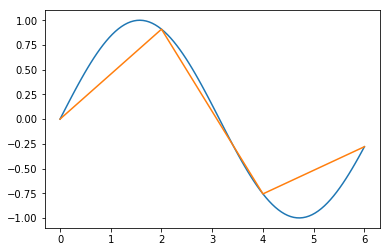

In [9]:
x_min = 0
x_max = 6
x_samples = 4

# Nonlinear function
f = lambda x: np.sin(x)

# Sampling the nonlinear function
xs = np.linspace(x_min,x_max,x_samples)
ys = np.array(f(xs))

x_ls = np.linspace(x_min,x_max,100)

plt.plot(x_ls,f(x_ls))
plt.plot(xs,ys)

In [10]:
x = pulp.LpVariable('x', lowBound=x_min, upBound=x_max)
y = pulp.LpVariable('y')
l = [pulp.LpVariable(f'lambda_{i}', lowBound=0, upBound=1) for i in range(x_samples)]
w = [pulp.LpVariable(f'w_{i}', cat='Binary') for i in range(x_samples-1)]

In [11]:
m = pulp.LpProblem("Linear Piecewise Approximation", sense=pulp.LpMinimize)

In [12]:
m += x == np.sum([xs[i] * l[i] for i in range(x_samples)])
m += y == np.sum([ys[i] * l[i] for i in range(x_samples)])
m += np.sum(l) == 1
m += np.sum(w) == 1
for i in range(x_samples-1): m += w[i] <= l[i] + l[i+1]

In [13]:
m += y

In [14]:
m

Linear Piecewise Approximation:
MINIMIZE
1*y + 0
SUBJECT TO
_C1: - 2 lambda_1 - 4 lambda_2 - 6 lambda_3 + x = 0

_C2: - 0.909297426826 lambda_1 + 0.756802495308 lambda_2
 + 0.279415498199 lambda_3 + y = 0

_C3: lambda_0 + lambda_1 + lambda_2 + lambda_3 = 1

_C4: w_0 + w_1 + w_2 = 1

_C5: - lambda_0 - lambda_1 + w_0 <= 0

_C6: - lambda_1 - lambda_2 + w_1 <= 0

_C7: - lambda_2 - lambda_3 + w_2 <= 0

VARIABLES
lambda_0 <= 1 Continuous
lambda_1 <= 1 Continuous
lambda_2 <= 1 Continuous
lambda_3 <= 1 Continuous
0 <= w_0 <= 1 Integer
0 <= w_1 <= 1 Integer
0 <= w_2 <= 1 Integer
x <= 6 Continuous
y free Continuous

In [15]:
status = m.solve()
pulp.LpStatus[status]

'Optimal'

In [16]:
x.value(), y.value()

(4.0, -0.7568025)

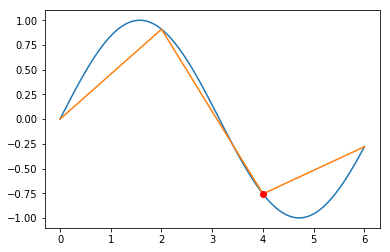

In [17]:
plt.plot(x_ls,f(x_ls))
plt.plot(xs,ys)
plt.plot(x.value(), y.value(), 'ro')